# 🛡️ The Digital Bouncer: NSL-KDD Intrusion Detection System

## 🎬 The Story: Hiring a Cyber-Guard
Imagine you run an exclusive club (your Network). You need a **Bouncer** at the door to check everyone trying to enter.
* Most bouncers can easily spot the local troublemakers they've seen before.
* **The real challenge?** Spotting a troublemaker who is wearing a disguise you've *never* seen before.

This is exactly what we are building today using the **NSL-KDD Dataset**.

## 🕵️‍♂️ The Mission
We are building an AI model to act as our **Digital Bouncer**. It analyzes network traffic logs and must make a split-second decision:
* ✅ **Normal:** A legitimate user. Let them in.
* 🚨 **Attack:** A hacker/intrusion attempt. **BLOCK THEM.**

## ⚠️ The Trap (The "Zero-Day" Reality)
Here is the twist that makes this project exciting (and frustrating):
The **Training Set** teaches our model specific attack patterns (like *Neptune* or *Smurf*).
**HOWEVER**, the **Test Set** contains **17 new types of attacks** that the model has *never* seen during training.

This simulates real-world **Zero-Day Attacks**. We cannot just teach the model to "memorize" attacks; we must teach it to understand **suspicious behavior**.

Let's start the interview process for our new Bouncer. 🚀

# Part I: The Setup & The Ledger (Initialization)
## Getting the tools ready and opening the guest list.

## 🧰 1. Equipping the Security Team (Imports)
Before we let the bouncer start working, we need to give him the right tools. We are importing standard data science libraries for manipulation and visualization.

In [56]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
import hvplot.pandas  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier)
from xgboost import XGBClassifier
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
import joblib

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 📂 2. Loading the "Naked" Data
Here is the first hurdle: **The NSL-KDD dataset usually comes without column names (headers).**
It's like receiving a list of guests without knowing which number represents their age, and which represents their ID.

If we just load it, we will see columns named `0`, `1`, `2`... which is useless.
**The Fix:** We will manually assign the 43 feature names based on the official documentation to make the data readable.

In [57]:
train_path = r"/kaggle/input/nslkdd/KDDTrain+.txt" 
test_path = r"/kaggle/input/nslkdd/KDDTest+.txt"

KDD_Train = pd.read_csv(train_path, header=None) 
KDD_Test = pd.read_csv(test_path, header=None)

# 🏷️ Naming the columns (The "Clothing" for our data)
connection_features = [
    'duration', 'protocol_type', 'service', 'flag']
traffic_features = [
    'src_bytes', 'dst_bytes']
basic_attack_features = [
    'land', 'wrong_fragment', 'urgent', 'hot']
login_features = [
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root']
system_features = [
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds']
user_features = [
    'is_host_login', 'is_guest_login']
time_based_features = [
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate']
host_based_features = [
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate']
target_columns = [
    'attack', # multi-class target
    'outcome'] # binary target (normal / attack)

# Combining all features
all_columns = (
    connection_features + traffic_features + basic_attack_features +
    login_features + system_features + user_features +
    time_based_features + host_based_features + target_columns
)

# Assigning columns to the DataFrames
KDD_Train.columns = all_columns
KDD_Test.columns = all_columns

print(f'Total columns: {len(all_columns)}')

Total columns: 43


## 📊 3. Crowd Control: How big is the traffic?
Before analyzing behavior, let's see how much traffic we are dealing with.
* **Training Set:** The traffic we know and have studied.
* **Test Set:** The "wild" traffic where we will be tested (contains unknown attacks).

In [58]:
print(f'Training Data Shape: {KDD_Train.shape}')
print(f'Testing Data Shape:  {KDD_Test.shape}')
print(f"Percentage of Testing Data: {len(KDD_Test)/(len(KDD_Train)+len(KDD_Test)):.2%}")

Training Data Shape: (125973, 43)
Testing Data Shape:  (22544, 43)
Percentage of Testing Data: 15.18%


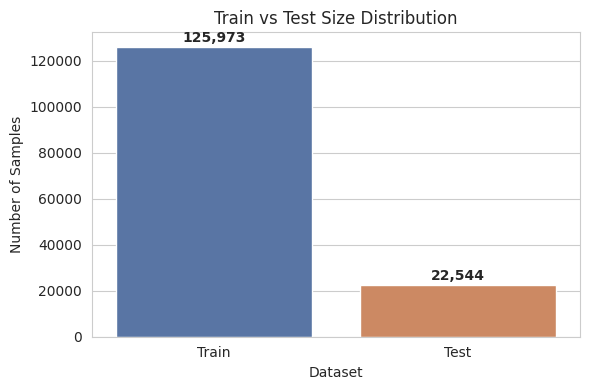

In [59]:
# Visualizing the split
size_df = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Samples": [KDD_Train.shape[0], KDD_Test.shape[0]]})

plt.figure(figsize=(6, 4))
sns.barplot(x="Dataset", y="Samples", data=size_df, palette=["#4C72B0", "#DD8452"])

for index, value in enumerate(size_df["Samples"]):
    plt.text(index, value + 1000, f"{value:,}", ha="center", va="bottom", fontsize=10, fontweight='bold')

plt.title("Train vs Test Size Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()

## 🔍 4. ID Check: A Closer Look
Let's inspect the data "passports". We need to ensure:
1.  The data looks correct (Head/Tail).
2.  There are no missing values (Nulls). **Missing values in cybersecurity are dangerous—they could be a glitch or an evasion attempt.**

In [60]:
print('-' * 30 + '\nDataset Preview (First 5 Rows) -> Training Data :\n')
display(KDD_Train.head())

print('-' * 30 + '\nDataset Preview (Last 5 Rows) -> Training Data :\n')
display(KDD_Train.tail())

------------------------------
Dataset Preview (First 5 Rows) -> Training Data :



,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,outcome
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


------------------------------
Dataset Preview (Last 5 Rows) -> Training Data :



,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,outcome
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.0,0.00,0.0,0.00,0.0,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.0,0.72,0.0,0.01,0.0,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125972,0,tcp,ftp_data,SF,151,0,0,0,0,0,...,0.30,0.03,0.30,0.0,0.00,0.0,0.00,0.0,normal,21


In [61]:
print("Missing Values Investigation")
print("Missing Values in Train:", KDD_Train.isnull().sum().sum())
print("Missing Values in Test:", KDD_Test.isnull().sum().sum())

Missing Values Investigation
Missing Values in Train: 0
Missing Values in Test: 0


In [62]:
print("Data Types Info")
KDD_Train.info()

Data Types Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-nu

# Part II: Scanning the Crowd (Data Cleaning & Inspection)
## Looking for errors, duplicates, and understanding who we are dealing with.

## 📉 5. The Radar Sweep (Statistical Summary)
Before we start cutting things out, the Bouncer takes a look at the general statistics of the crowd.
We are looking for weird numbers: Are there negative values? Are the standard deviations too high?

In [63]:
KDD_Train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


## 🗑️ 6. Trimming the Fat (Redundant Features)
A good Bouncer focuses on what matters.
* **Constant Columns:** If a feature has the same value for *everyone* (e.g., everyone is wearing shoes), it doesn't help us distinguish between a Normal User and a Hacker. It's useless noise.
* **Unique IDs:** If a feature is 100% unique for every row, it's just an ID. The model might memorize it instead of learning a pattern (Overfitting).

We are writing a script to hunt these "useless" columns down.

In [64]:
constant_cols = []
for column in KDD_Train.columns:
    n_unique = KDD_Train[column].nunique()
    print(f"{column}: Number of unique values = {n_unique}")
    print("--------------------------------------------------")
    if n_unique == 1 or n_unique == KDD_Train.shape[0]:
        constant_cols.append(column) 
print("Constant columns")
print(constant_cols)

duration: Number of unique values = 2981
--------------------------------------------------
protocol_type: Number of unique values = 3
--------------------------------------------------
service: Number of unique values = 70
--------------------------------------------------
flag: Number of unique values = 11
--------------------------------------------------
src_bytes: Number of unique values = 3341
--------------------------------------------------
dst_bytes: Number of unique values = 9326
--------------------------------------------------
land: Number of unique values = 2
--------------------------------------------------
wrong_fragment: Number of unique values = 3
--------------------------------------------------
urgent: Number of unique values = 4
--------------------------------------------------
hot: Number of unique values = 28
--------------------------------------------------
num_failed_logins: Number of unique values = 6
--------------------------------------------------
log

## ✂️ 7. Ejecting the Noise
Now that we identified the **Constant Columns** (and the extra `outcome` column which we don't need since we have `attack`), it's time to drop them.
This makes our dataset lighter and our model faster.

In [65]:
KDD_Train.drop(columns=constant_cols + ['outcome'], inplace=True)
KDD_Test.drop(columns=constant_cols + ['outcome'], inplace=True)

## 📏 8. Establishing Boundaries (Min/Max Check)
To understand the traffic, we need to know the limits.
* What is the minimum duration of a connection?
* What is the maximum number of bytes sent?

This loop checks all **Numeric (Continuous)** features and prints their range. This helps us spot if we need **Scaling** later (spoiler: we usually do).

In [66]:
cont_col = []
for column in KDD_Train.columns:
    if KDD_Train[column].dtypes != object:
        print(f"{column} : Minimum: {KDD_Train[column].min()}, Maximum: {KDD_Train[column].max()}")
        cont_col.append(column)
        print("--------------------------------------------------")

duration : Minimum: 0, Maximum: 42908
--------------------------------------------------
src_bytes : Minimum: 0, Maximum: 1379963888
--------------------------------------------------
dst_bytes : Minimum: 0, Maximum: 1309937401
--------------------------------------------------
land : Minimum: 0, Maximum: 1
--------------------------------------------------
wrong_fragment : Minimum: 0, Maximum: 3
--------------------------------------------------
urgent : Minimum: 0, Maximum: 3
--------------------------------------------------
hot : Minimum: 0, Maximum: 77
--------------------------------------------------
num_failed_logins : Minimum: 0, Maximum: 5
--------------------------------------------------
logged_in : Minimum: 0, Maximum: 1
--------------------------------------------------
num_compromised : Minimum: 0, Maximum: 7479
--------------------------------------------------
root_shell : Minimum: 0, Maximum: 1
--------------------------------------------------
su_attempted : Minimum:

## 🎯 9. Defining the Enemy (Binary Classification)
Our Bouncer currently sees many types of attacks (Smurf, Neptune, Satan...).
To simplify his job first, let's just ask him to identify: **Is this a Friend (Normal) or a Foe (Attack)?**

We are creating a new column `is_intrusion` to merge all attack types into one category.

In [67]:
KDD_Train_intrusion = KDD_Train.attack.map(lambda x: 'normal' if x == 'normal' else 'attack')
KDD_Test_intrusion = KDD_Test.attack.map(lambda x: 'normal' if x == 'normal' else 'attack')
KDD_Train['is_intrusion'] = KDD_Train_intrusion
KDD_Test['is_intrusion'] = KDD_Test_intrusion

## ⚖️ 10. The Balance of Power
Is our club full of regular people or full of criminals?
We need to check the balance. If the dataset is 99% Normal and 1% Attacks, the Bouncer might get lazy and just say "Normal" to everyone to get a 99% accuracy score (which would be a disaster).

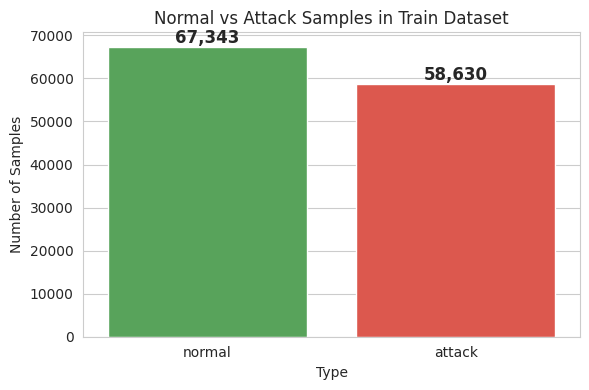

In [68]:
intrusion_counts = KDD_Train['is_intrusion'].value_counts().reset_index()
intrusion_counts.columns = ['Type', 'Count']

plt.figure(figsize=(6, 4))
sns.barplot(x="Type", y="Count", data=intrusion_counts, palette=["#4CAF50", "#F44336"])

for index, value in enumerate(intrusion_counts["Count"]):
    plt.text(index, value, f"{value:,}", ha="center", va="bottom", fontsize=12, fontweight='bold')

plt.title("Normal vs Attack Samples in Train Dataset")
plt.ylabel("Number of Samples")
plt.xlabel("Type")
plt.tight_layout()
plt.show()

## 🚩 11. Outliers Analysis: Error or Attack?
When data scientists analyze data, they usually remove "Outliers" (extreme values) because they are considered errors.
**However, in Network Security, the logic is reversed.**

### 💳 The "Credit Card Thief" Analogy
Imagine monitoring credit card transactions:
* **Normal User:** Spends $50, $100, or maybe $200.
* **Thief (Attack):** Tries to steal **$50,000** at once.

If we treat the $50,000 as an "Outlier" and remove it, **we are removing the thief!**

### 📉 Visualizing the Truth
In the NSL-KDD dataset, attacks like **DoS (Denial of Service)** behave exactly like the thief:
* **Normal Traffic:** Sends a small amount of bytes (Low values).
* **Attack Traffic:** Sends millions of bytes to crash the server (Extreme values).

**Conclusion:** In the graphs below, the "dots" at the top are not errors. They are the attacks we want to detect. We will keep them and use **Log Transformation** to handle the scale difference.

In [69]:
cols_to_plot = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate']
log_cols = ['src_bytes', 'dst_bytes', 'duration']
plots_list = []

for col in cols_to_plot:
    df_temp = KDD_Train[[col, 'is_intrusion']].copy()
    y_label = col
    # Applying Log Transformation for better visualization of "Thieves"
    if col in log_cols:
        df_temp[col] = np.log1p(df_temp[col])
        y_label = f'Log({col})'
    
    box = df_temp.hvplot.box(
        y=col, 
        by='is_intrusion',      
        c='is_intrusion',       
        cmap=['#4CAF50', '#F44336'], 
        title=f'Analysis of: {col}',
        ylabel=y_label,
        xlabel='',              
        width=380,              
        height=300,             
        legend=False )
    plots_list.append(box)
# Displaying the grid of plots
layout = hv.Layout(plots_list).cols(3)
layout

:Layout
   .BoxWhisker.I   :BoxWhisker   [is_intrusion]   (duration)
   .BoxWhisker.II  :BoxWhisker   [is_intrusion]   (src_bytes)
   .BoxWhisker.III :BoxWhisker   [is_intrusion]   (dst_bytes)
   .BoxWhisker.IV  :BoxWhisker   [is_intrusion]   (count)
   .BoxWhisker.V   :BoxWhisker   [is_intrusion]   (srv_count)
   .BoxWhisker.VI  :BoxWhisker   [is_intrusion]   (serror_rate)

# Part III: Profiling the Suspects (Exploratory Data Analysis)
## Understanding the behavior of the gangs (Protocols, Services, Flags).

## 🗂️ 12. Grouping the Gangs (Attack Categorization)
The Bouncer has a list of specific criminals (`neptune`, `satan`, `smurf`...), but it's easier to track them if we group them into **4 Main Gangs**:

1.  **DoS (Denial of Service):** The loud ones. They try to crash the club by overcrowding it.
2.  **Probe:** The spies. They walk around checking for unlocked doors.
3.  **R2L (Remote to Local):** The hackers. They try to guess passwords to get in from the outside.
4.  **U2R (User to Root):** The traitors. They are already inside (normal users) but try to become managers (Root access).

We will map every single attack to one of these 4 gangs.

In [70]:
attack_dict = {
    'normal': 'Normal',
    # DoS attacks
    'neptune': 'DoS', 'back': 'DoS', 'land': 'DoS', 'pod': 'DoS', 'smurf': 'DoS',
    'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS',
    'udpstorm': 'DoS',
    # Probe attacks
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
    'mscan': 'Probe', 'saint': 'Probe',
    # R2L attacks
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L',
    'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'sendmail': 'R2L', 'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'worm': 'R2L',
    # U2R attacks
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    'httptunnel': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R'}

KDD_Train['attack_class'] = KDD_Train['attack'].map(attack_dict)

# Prepare data for heatmap
attack_class_proto = pd.crosstab(KDD_Train['attack_class'], KDD_Train['protocol_type'])
df_heatmap = attack_class_proto.reset_index().melt(id_vars='attack_class', 
                                                   var_name='protocol_type', 
                                                   value_name='count')

## 🚪 13. Modus Operandi: The Protocols
How does each gang try to enter?
* **TCP:** The main entrance. Used by normal people and many attackers.
* **UDP:** The back window. Often used by spies (Probe).
* **ICMP:** The doorbell. **DoS attackers** love to ring the doorbell a million times to annoy us (Smurf attack).

Let's visualize this relationship.

In [71]:
# Heatmap: Intensity of attacks per protocol
heatmap = df_heatmap.hvplot.heatmap(
    x='protocol_type', y='attack_class', 
    C='count', cmap='YlOrRd',            
    title='Attack Classes vs. Protocols',
    height=500, width=700,
    colorbar=True, tools=['hover'])

labels = df_heatmap.hvplot.labels(x='protocol_type', 
    y='attack_class', text='count', text_color='black')

plot = heatmap * labels
display(plot) 

:Overlay
   .HeatMap.I :HeatMap   [protocol_type,attack_class]   (count)
   .Labels.I  :Labels   [protocol_type,attack_class]   (count)

In [72]:
# Bar Chart: Another view of the same data
attack_counts = KDD_Train.groupby(['attack_class', 'protocol_type']).size().reset_index(name='count')
attack_counts.hvplot.bar( x='attack_class', y='count',               
    by='protocol_type',stacked=False, cmap='Set2',          
    title='Distribution of Attack Classes by Protocol',
    xlabel='Attack Class',ylabel='Count',
    height=500, width=800, legend='top_right')

:Bars   [attack_class,protocol_type]   (count)

## 🏢 14. The Scene of the Crime: Services
Which "room" in our club is being targeted?
* **HTTP:** The main lobby. Mostly safe, but huge traffic.
* **Private:** A restricted area. **Suspiciously high amount of attacks happen here.**
* **Ecr_i:** If you see this, it's almost certainly an attack.

Zoom in on the chart below to see which services are "safe havens" and which are "war zones".

In [73]:
service_counts = KDD_Train.groupby(['service', 'is_intrusion']).size().reset_index(name='counts')
service_plot = service_counts.hvplot.bar( x='service', y='counts', 
    by='is_intrusion', stacked=True, height=600, width=1200,             
    rot=90, color=['#F44336', '#4CAF50'],
    title="All 70 Network Services: Interactive Analysis (Zoom in!)",
    xlabel='Service Type', ylabel='Total Connections',tools=['hover'])
service_plot

:Bars   [service,is_intrusion]   (counts)

## 🚩 15. The Secret Handshake: Flags
Network connections have "Flags" that indicate the state of the conversation.
* **SF (Standard Flag):** "Hello, how are you?" "I am fine." -> **Normal**.
* **S0 (S-Zero):** "Hello?" ... (No response). -> **Suspicious (Neptune Attack).**
* **REJ (Reject):** "Go away!" -> **Attack attempt blocked.**

The chart below proves that **SF** is mostly normal, while **S0** is almost 100% malicious.

In [74]:
flag_counts = KDD_Train.groupby(['flag', 'is_intrusion']).size().reset_index(name='counts')
flag_plot = flag_counts.hvplot.bar(x='flag', y='counts', 
    by='is_intrusion', stacked=True, height=500, width=900,              
    color=['#F44336', '#4CAF50'],
    title="Network Flags Analysis: Interactive (No Log Scale)",
    xlabel='Flag Type (e.g., SF, S0, REJ)',
    ylabel='Connection Count',
    tools=['hover'])

flag_plot

:Bars   [flag,is_intrusion]   (counts)

## 👯 16. Cutting the Echo (Correlation Analysis)
The Bouncer is smart. He hates redundancy.
If two sensors tell him the exact same thing (e.g., `num_root` and `num_compromised` might be 99% identical), he doesn't need to check both. It's a waste of time.

We will calculate the **Correlation Matrix** to find these "echoes".
* **Red (1.0):** Perfect match.
* **Logic:** If Correlation > 95%, we drop one of the two columns.

In [75]:
numerical_cols = KDD_Train.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_cols.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_masked = corr_matrix.mask(mask)

df_corr = corr_masked.stack().reset_index()
df_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Plotting the Heatmap
display(df_corr.hvplot.heatmap( x='Variable 1', y='Variable 2',
    C='Correlation', cmap='crest',        
    clim=(-1, 1), title='Correlation Matrix (Red = High Correlation)',
    height=700, width=1000, rot=45, tools=['hover'],).opts(
    line_color='white', line_width=0.5, xaxis='bottom'))

# Helper functions to identify redundant features
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_correlations(df, threshold=0.9):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[au_corr > threshold]

print("Highly Correlated Features (Candidates to Drop):")
print(get_top_correlations(numerical_cols, threshold=0.95))

:HeatMap   [Variable 1,Variable 2]   (Correlation)

Highly Correlated Features (Candidates to Drop):
num_compromised       num_root                    0.998833
serror_rate           srv_serror_rate             0.993289
rerror_rate           srv_rerror_rate             0.989008
srv_serror_rate       dst_host_srv_serror_rate    0.986252
dst_host_serror_rate  dst_host_srv_serror_rate    0.985052
serror_rate           dst_host_srv_serror_rate    0.981139
                      dst_host_serror_rate        0.979373
srv_serror_rate       dst_host_serror_rate        0.977596
srv_rerror_rate       dst_host_srv_rerror_rate    0.970208
rerror_rate           dst_host_srv_rerror_rate    0.964449
dtype: float64


In [76]:
# Dropping the Redundant Columns
corr_matrix = KDD_Train.select_dtypes(include=['float64', 'int64']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Columns detected as redundant (Correlation > 95%): \n{to_drop}")
print(f"Count: {len(to_drop)} columns")

KDD_Train.drop(columns=to_drop, inplace=True)
KDD_Test.drop(columns=to_drop, inplace=True)

print("-" * 30)
print(f"New Training Shape: {KDD_Train.shape}")
print(f"New Testing Shape: {KDD_Test.shape}")

Columns detected as redundant (Correlation > 95%): 
['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate']
Count: 6 columns
------------------------------
New Training Shape: (125973, 37)
New Testing Shape: (22544, 36)


# Part IV: Training Camp (Preprocessing)
## Translating human data into robot language so the Bouncer can learn.

## 🧹 17. Cleaning the Workspace
We are done with the analysis. The Bouncer now knows who the gangs are.
Now, we need to prepare the "Final Exam" paper.
* We drop the detailed labels (`attack`, `attack_class`) because we only care about the binary question: **Intrusion (1) or Normal (0)?**
* We check for any "Ghost Columns" (columns present in Train but missing in Test, or vice-versa).

In [77]:
# Checking for mismatched columns before dropping
diff = set(KDD_Train.columns) - set(KDD_Test.columns)
print(f"The ghost column is: {diff}")

The ghost column is: {'attack_class'}


In [78]:
# Dropping the helper columns we created for visualization
cols_to_cleanup = ['attack', 'attack_class']

KDD_Train.drop(columns=cols_to_cleanup, errors='ignore', inplace=True)
KDD_Test.drop(columns=cols_to_cleanup, errors='ignore', inplace=True)

print("-" * 30)
print(f"Final Training Shape: {KDD_Train.shape}")
print(f"Final Testing Shape:  {KDD_Test.shape}")

------------------------------
Final Training Shape: (125973, 35)
Final Testing Shape:  (22544, 35)


## ✂️ 18. Separating Questions from Answers (X and y)
Standard procedure:
* **X:** The evidence (Features).
* **y:** The verdict (Is it an intrusion?).

In [79]:
X_train = KDD_Train.drop('is_intrusion', axis=1)
y_train = KDD_Train['is_intrusion']

X_test = KDD_Test.drop('is_intrusion', axis=1)
y_test = KDD_Test['is_intrusion']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (125973, 34)
y_train shape: (125973,)


## 🗣️ 19. Translating to "Robot Language" (One-Hot Encoding)
The model cannot understand words like "TCP", "HTTP", or "SF". We must translate them into numbers.
We use **One-Hot Encoding**:
* `TCP` becomes `[1, 0, 0]`
* `UDP` becomes `[0, 1, 0]`

**The Trap:** The Training set might have a service (e.g., `aol`) that never appears in the Test set. This creates different shapes!

In [80]:
X_train = pd.get_dummies(X_train, columns=['protocol_type', 'service', 'flag'])
X_test = pd.get_dummies(X_test, columns=['protocol_type', 'service', 'flag'])

print("After Encoding:")
print(f"Train columns: {X_train.shape[1]}")
print(f"Test columns: {X_test.shape[1]}")

After Encoding:
Train columns: 115
Test columns: 109


## 🧩 20. The "Missing Guest" Fix (Reindexing)
**CRITICAL STEP:**
As expected, the shapes are different! (Train has more columns because it saw more service types).
If we feed this to the model, it will crash.

**The Fix:** We force the Test set to have the exact same columns as the Train set.
* If a column is missing in Test, we add it and fill it with `0`.
* This ensures our Bouncer is looking at the exact same checklist for everyone.

In [81]:
# Aligning the columns
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

print("-" * 30)
print(f"Final Train Shape: {X_train.shape}")
print(f"Final Test Shape:  {X_test.shape}")

------------------------------
Final Train Shape: (125973, 115)
Final Test Shape:  (22544, 115)


## ⚖️ 21. Leveling the Playing Field (Scaling)
Imagine comparing:
* `num_failed_logins` = 5
* `src_bytes` = 5,000,000

To the model, 5,000,000 is infinitely more important than 5. This is wrong.
We use **StandardScaler** to squash all numbers into the same range (usually around -1 to 1).
Now, 5 failed logins can be just as important as 5 million bytes.

In [82]:
scaler = StandardScaler()
# Scaling only numerical columns
cols_to_scale = X_train.select_dtypes(include=['float64', 'int64']).columns

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Data Scaled Successfully!")
display(X_train.head())

Data Scaled Successfully!


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.110249,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,False,False,False,False,False,False,False,False,True,False
1,-0.110249,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,False,False,False,False,False,False,False,False,True,False
2,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,False,False,False,False,True,False,False,False,False,False
3,-0.110249,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,False,False,False,False,False,False,False,False,True,False
4,-0.110249,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,False,False,False,False,False,False,False,False,True,False


## 🎯 22. Final Preparation
Finally, converting the target `y` into binary integers:
* **Normal** = 0
* **Attack** = 1

In [83]:
y_train = y_train.apply(lambda x: 0 if x == 'normal' else 1)
y_test = y_test.apply(lambda x: 0 if x == 'normal' else 1)

print("Target Distribution (Train):")
print(y_train.value_counts())

Target Distribution (Train):
is_intrusion
0    67343
1    58630
Name: count, dtype: int64


# Part V: The Arena (Modeling & Evaluation)
## The stress test. Sending the Bouncer to face unknown threats.

## 🏟️ 23. The Arena: Call to Arms
We are looking for the best Bouncer. To find him, we will host a tournament.
We have invited 7 candidates (Algorithms), ranging from the simple and fast to the complex and powerful:

1.  **Logistic Regression:** The old-school guard. Simple, linear, maybe too simple.
2.  **Naive Bayes:** The probabilistic guard. Good with text, let's see how he handles packets.
3.  **Decision Tree:** Asks a series of questions ("Is duration > 0?").
4.  **Random Forest:** A committee of Decision Trees. Very strong.
5.  **AdaBoost / Gradient Boosting:** They learn from their mistakes.
6.  **XGBoost:** The heavy hitter. The current champion of Kaggle competitions.

Let's initialize them.

In [84]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME', random_state=42), 
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

## ⚔️ 24. The Battle (Training & Testing on "Unknown" Ground)
**⚠️ CRITICAL NOTE: The Trap of 99% Accuracy**

If you look at other notebooks, you might see accuracies of 99.9%. **Don't be fooled.**
Those models are usually tested on a subset of the *Training Data* (the easy exam). The model already knows the attack signatures.

**What we are doing here is much harder:**
We are training on `Train+` but testing on `Test+`.
The `Test+` dataset contains **17 specific attack types** (like `mscan`, `saint`) that are **NOT** in the training set.

This simulates a real-world **Zero-Day Attack** scenario. A score of 75-80% here is actually **excellent** because it means the model is catching attacks it has *never* seen before.

Let the battle begin! 🔔

In [85]:
results = []
print("Welcome to the Model Arena! Let the battle begin...\n")
print(f"{'Model Name':<25} | {'Accuracy':<10} | {'Time (s)':<10}")
print("-" * 50)

for name, model in models.items():
    start_time = time.time()
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "Time (s)": elapsed_time
    })
    
    print(f"{name:<25} | {acc:.2%}    | {elapsed_time:.2f}")

Welcome to the Model Arena! Let the battle begin...

Model Name                | Accuracy   | Time (s)  
--------------------------------------------------
Logistic Regression       | 75.52%    | 6.73
Naive Bayes               | 51.23%    | 0.39
Decision Tree             | 80.90%    | 1.53
Random Forest             | 77.75%    | 4.58
AdaBoost                  | 78.60%    | 9.80
Gradient Boosting         | 78.91%    | 36.39
XGBoost                   | 78.76%    | 2.09


## 🏆 25. Crowning the Champion
The dust has settled. Who is our new Digital Bouncer?
We look for a balance between **Accuracy** (catching bad guys) and **Time** (speed). A Bouncer who takes 10 minutes to check an ID is useless.

In [86]:
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

print("\n🏆 Final Leaderboard:")
display(results_df)


🏆 Final Leaderboard:


,Model,Accuracy,Precision,Recall,F1-Score,Time (s)
2,Decision Tree,0.808996,0.965295,0.689239,0.804237,1.534390
5,Gradient Boosting,0.789079,0.970307,0.649342,0.778022,36.390150
6,XGBoost,0.787571,0.968110,0.648173,0.776476,2.088326
4,AdaBoost,0.786018,0.964937,0.647627,0.775063,9.797156
3,Random Forest,0.777502,0.968926,0.629315,0.763039,4.577288
0,Logistic Regression,0.755234,0.917380,0.626432,0.744490,6.726810
1,Naive Bayes,0.512287,0.967923,0.148134,0.256944,0.392630


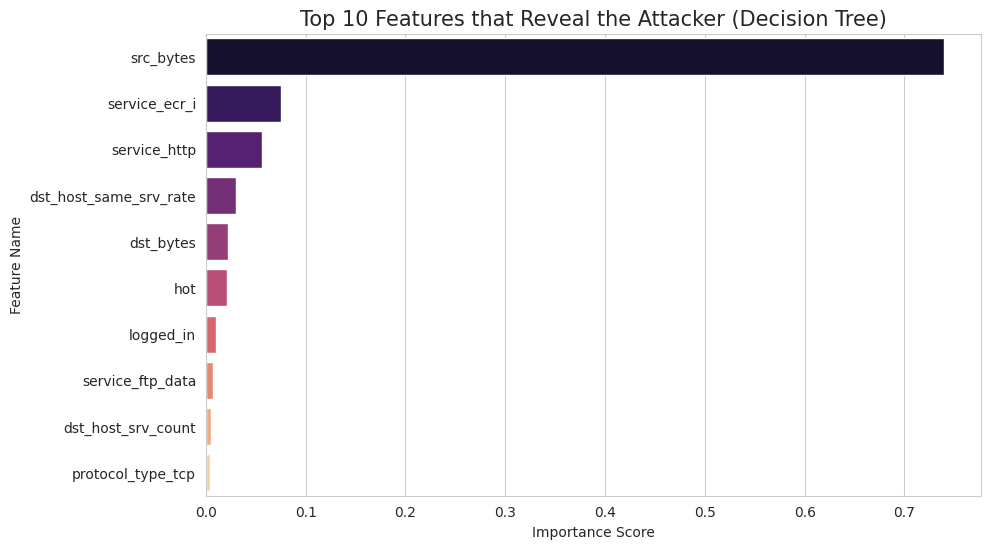

The Bouncer's Secret Rulebook:
1. src_bytes (0.7397)
2. service_ecr_i (0.0754)
3. service_http (0.0563)
4. dst_host_same_srv_rate (0.0302)
5. dst_bytes (0.0222)
6. hot (0.0216)
7. logged_in (0.0102)
8. service_ftp_data (0.0072)
9. dst_host_srv_count (0.0046)
10. protocol_type_tcp (0.0044)


In [87]:
winner_model = models['Decision Tree']

importances = winner_model.feature_importances_
indices = np.argsort(importances)[::-1] 

top_n = 10
top_features = [X_train.columns[i] for i in indices[:top_n]]
top_importances = importances[indices[:top_n]]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette="magma")
plt.title('Top 10 Features that Reveal the Attacker (Decision Tree)', fontsize=15)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

print("The Bouncer's Secret Rulebook:")
for i in range(top_n):
    print(f"{i+1}. {top_features[i]} ({top_importances[i]:.4f})")

## 🏆 26. The Final Verdict: A "David vs. Goliath" Moment

We threw everything at the problem: simple algorithms, complex ensembles, and the legendary gradient boosters.
We expected the heavyweights (**Random Forest, XGBoost**) to crush the competition.

### 😲 The Plot Twist
**We witnessed a shocking upset!**
The complex models over-thought the problem, while the simplest model stole the show.

### 🥇 The Winner: Decision Tree (80.90%)
The humble **Decision Tree** outperformed the sophisticated Random Forest and Gradient Boosting.
* **The "Bouncer" Logic:** In the world of Zero-Day attacks, sometimes you don't need a committee voting (Random Forest). You need a Bouncer with a **strict, sharp rulebook**.
* **Why it won:** The Decision Tree created hard, specific boundaries. When a new attack appeared that looked *slightly* like an old one, the Tree said "Block it!", while the Random Forest tried to "average out" the decision and hesitated.

### 📉 The Loser: Naive Bayes (51.2%)
With an accuracy of ~51%, this model is statistically as good as **flipping a coin**.
* **Why it failed:** Naive Bayes assumes that features are independent (e.g., that `duration` has nothing to do with `service`). In Network Traffic, everything is connected. This assumption killed its performance.

### ⏱️ Speed vs. Accuracy (Efficiency Check)
* **🏎️ The Sprinter:** Naive Bayes (0.4s) - Fast but wrong.
* **⚡ The Efficient Pro:** Decision Tree (1.6s) - Very fast and the most accurate.
* **🐢 The Heavyweight:** Gradient Boosting took ~37s to learn, yet couldn't beat the simple Tree.

### 📝 Conclusion
**Complexity $\neq$ Intelligence.**
We don't always need a Supercomputer. Sometimes, a smart Bouncer with a sharp set of rules is all you need to keep the network safe.

# Part VI: The Revelation (The Twist)

## 🎭 27. The "99% Accuracy" Illusion (The Easy Mode)
You might wonder: **"Why do I see other projects claiming 99.9% accuracy on this dataset?"**

Here is the secret: **They are taking the easy way out.**
Instead of testing on the **Unknown Attacks** (KDDTest+), they simply split the **Training Data** into two parts (Train/Test).
* **The Problem:** The model memorizes the attack signatures.
* **The Result:** It gets a perfect score on the exam because it has seen the questions before!

Let's prove this theory by running a **Random Forest** on a simple split of the training data.

In [88]:
# 1. Splitting the Training Data (The "Easy" Exam)
X_train_easy, X_test_easy, y_train_easy, y_test_easy = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

# 2. Training the Model
print("Training Random Forest on Internal Split (Easy Mode)...")
rf_easy = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_easy.fit(X_train_easy, y_train_easy)

# 3. Testing
y_pred_easy = rf_easy.predict(X_test_easy)
acc_easy = accuracy_score(y_test_easy, y_pred_easy)

print("\n" + "="*40)
print(f"ACCURACY ON INTERNAL SPLIT: {acc_easy:.4%}")
print("="*40)
print("\nSee the difference? We jumped from ~80% to ~99%.")
print("This proves that our lower score earlier was NOT a failure.")
print("It was a measure of REAL-WORLD robustness against Zero-Day attacks.")

Training Random Forest on Internal Split (Easy Mode)...

ACCURACY ON INTERNAL SPLIT: 99.8783%

See the difference? We jumped from ~80% to ~99%.
This proves that our lower score earlier was NOT a failure.
It was a measure of REAL-WORLD robustness against Zero-Day attacks.


## 🎬 28. Conclusion: The Final Report
We started this journey to build a **Digital Bouncer** capable of spotting not just known criminals, but also new threats in disguise.

### 📝 Summary of Findings:
1.  **The Challenge:** The NSL-KDD dataset is tricky. The Test set contains **17 attack types** not found in the Train set (Zero-Day Attacks).
2.  **The Reality:** A model achieving **~81% accuracy** on `KDDTest+` (like our Decision Tree) is performing exceptionally well. It demonstrates true **Generalization**.
3.  **The Illusion:** Achieving 99% is easy if you only test on known data, but that model will fail in the real world when a new hacker shows up.

### 🏆 The Champion
Our **Decision Tree** proved that a simple, strict rulebook is better than a complex committee for detecting unknown threats. It is fast, efficient, and robust.

**Mission Accomplished. The Network is Safe. 🛡️🚀**

In [89]:
joblib.dump(winner_model, 'bouncer_model.pkl')
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'model_columns.pkl')

print("Model & Columns saved successfully! Download them now.")

Model & Columns saved successfully! Download them now.
